In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm

import bayesflow as bf
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential

import sys
sys.path.append("../assets/")
from priors import sample_eta, sample_random_walk
from likelihood import sample_non_stationary_diffusion_process, _sample_diffusion_trial
from context import generate_context
from configurations import approximator_settings    

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Constants

In [102]:
TRAIN_NETWORK = False
FIT_MODEL = False

In [114]:
NUM_OBS = 246
RT_UPPER_BOUND = 6.0
RT_LOWER_BOUND = 0.2
NUM_SAMPLES = 2000
NUM_RESIMULATIONS = 500

LOCAL_PARAM_LABELS = [
    'Base drift rate', 'Sensitivity', 'Threshold', 'Bias',
    'Non-decision time', 'Non-decision time', 'Non-decision time'
]
LOCAL_PARAM_NAMES  = [
    r'v_0', r'b_v', r'a', r'\beta', r'\tau_1', r'\tau_2', r'\tau_3'
]

FONT_SIZE_1 = 20
FONT_SIZE_2 = 18
FONT_SIZE_3 = 14

## Exemplar parameter trajectory

In [4]:
eta = sample_eta()
theta_t = sample_random_walk(eta)

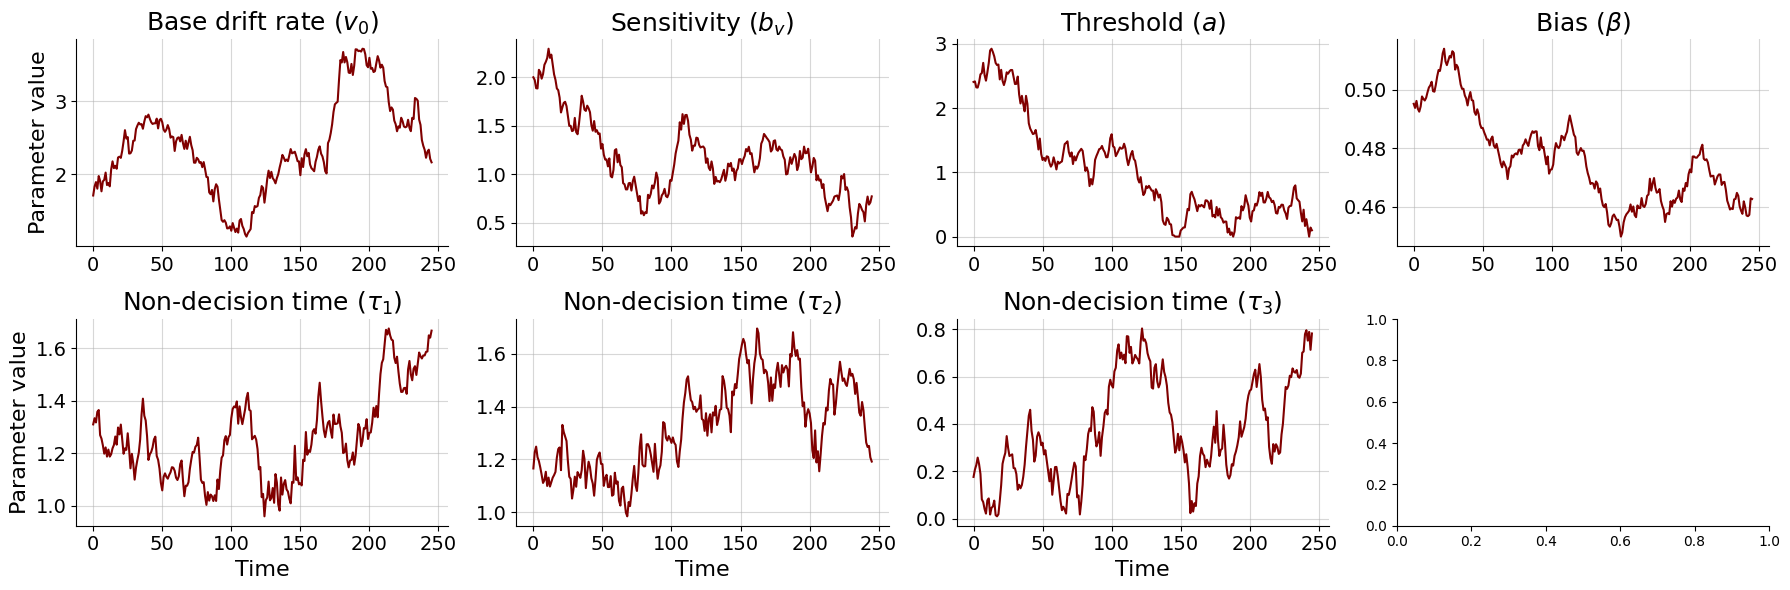

In [5]:
time = np.arange(theta_t.shape[0])
fig, axarr = plt.subplots(2, 4, figsize=(18, 6))
for i, ax in enumerate(axarr.flat):
    if i == 7:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta_t[:, i],
        color='maroon'
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    if i > 3:
        ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Generative Model

In [6]:
prior = bf.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_eta,
    local_prior_fun=sample_random_walk,
    )

context = bf.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
    )

likelihood = bf.simulation.Simulator(
    simulator_fun=sample_non_stationary_diffusion_process,
    context_generator=context,
    )

model = bf.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="random_walk_diffusion_model",
)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 246, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 246, 2)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 246, 7)
INFO:root:No shared_prior_draws provided.
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


## Configurator

In [7]:
N = 50000
prior_samples = prior(N)

In [8]:
HYPER_PRIOR_MEAN = np.round(prior_samples['hyper_parameters'].mean(axis=0), 2)
HYPER_PRIOR_STD = np.round(prior_samples['hyper_parameters'].std(axis=0), 2)

local_samples = prior_samples['local_parameters'].reshape(-1, prior_samples['local_parameters'].shape[-1])
LOCAL_PRIOR_MEAN = np.round(local_samples.mean(axis=0), 2)
LOCAL_PRIOR_STD = np.round(local_samples.std(axis=0), 2)

In [9]:
def configure_input(raw_dict):
    # prepare data
    data = raw_dict.get("sim_data")
    truth_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 0][:, :, None]
    face_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 1][:, :, None]
    validity_context = np.array(raw_dict.get("sim_batchable_context"))[:, :, 2][:, :, None]
    summary_conditions = np.c_[data, truth_context, to_categorical(face_context), validity_context]

    theta_t = raw_dict.get("local_prior_draws")
    eta = raw_dict.get("hyper_prior_draws")

    out_dict = dict(
        local_parameters=((theta_t - LOCAL_PRIOR_MEAN) / LOCAL_PRIOR_STD).astype(np.float32),
        hyper_parameters=((eta - HYPER_PRIOR_MEAN) / HYPER_PRIOR_STD).astype(np.float32),
        summary_conditions=summary_conditions.astype(np.float32),
    )
    return out_dict

# Neural Approximator

In [10]:
summary_network = bf.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [11]:
local_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=7,
        **approximator_settings.get("local_amortizer_settings")
    )
)

global_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=5,
        **approximator_settings.get("global_amortizer_settings")
    )
)

In [12]:
amortizer = bf.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/model_1"
)

INFO:root:Loaded loss history from ../checkpoints/model_1/history_100.pkl.
INFO:root:Networks loaded from ../checkpoints/model_1/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training

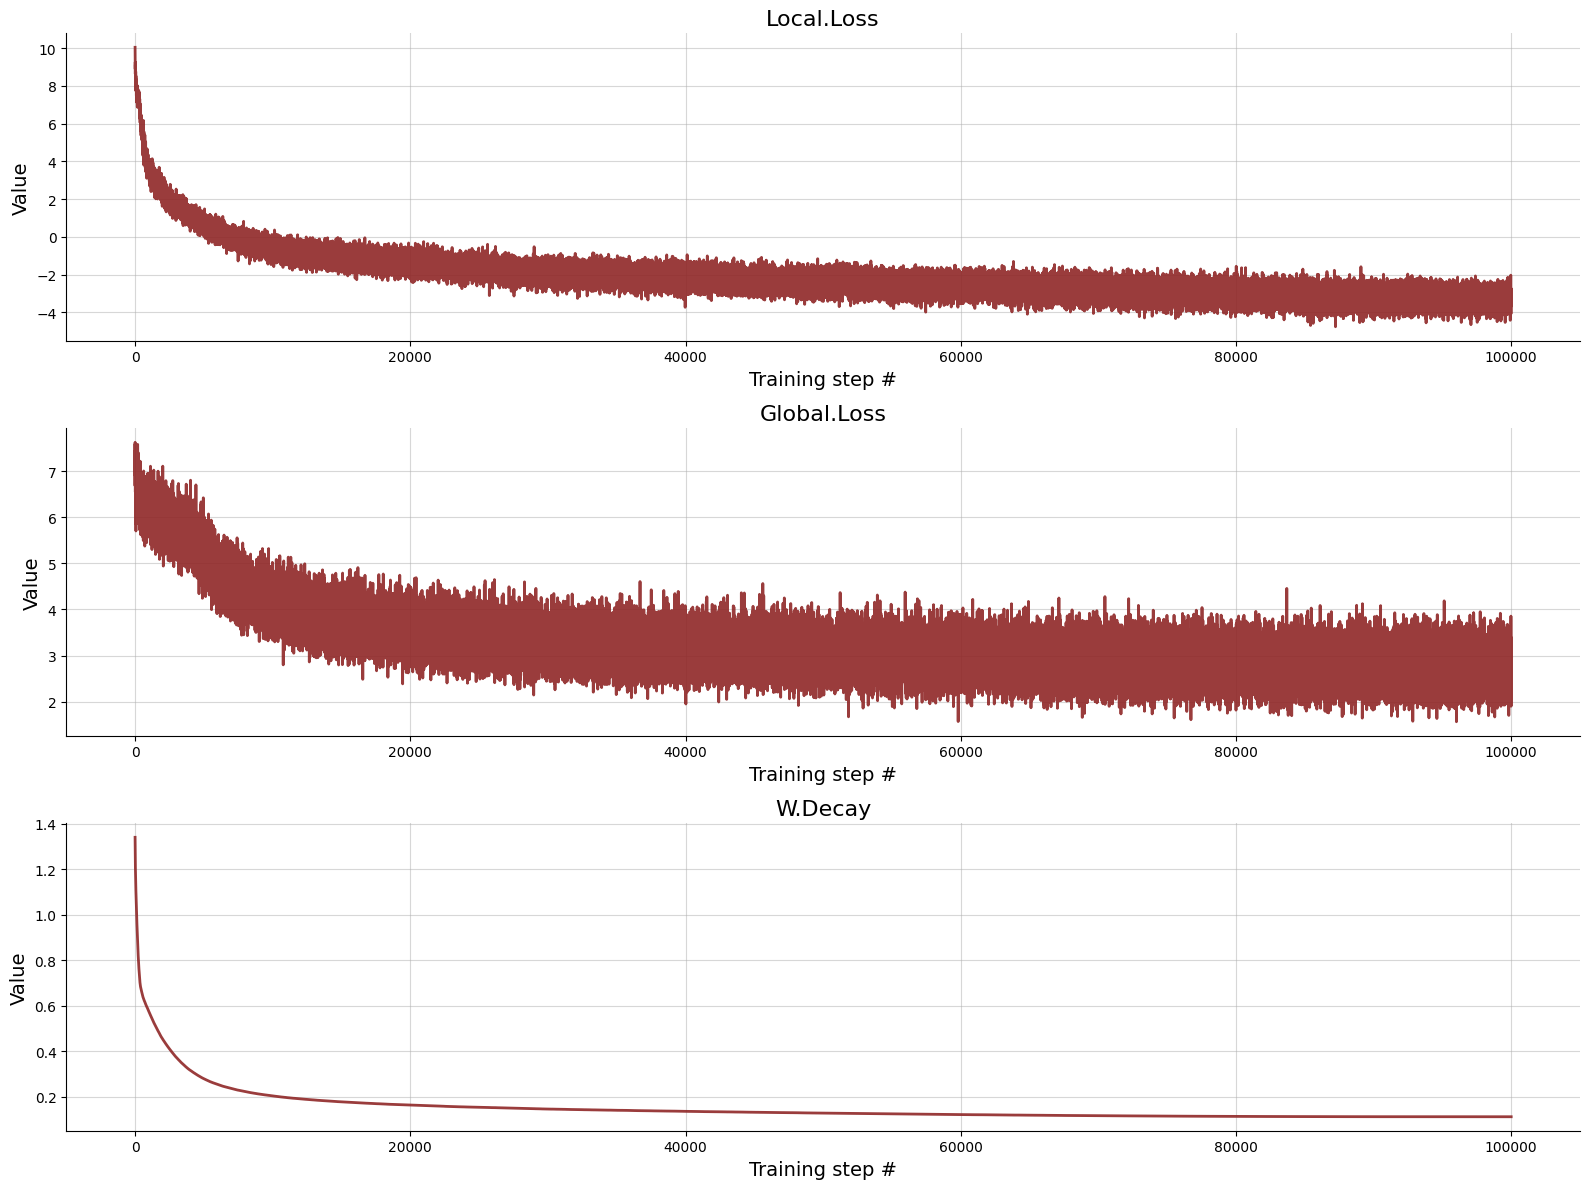

In [13]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=100,
        iterations_per_epoch=1000,
        batch_size=32
    )
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())
else:
    loss_plot = bf.diagnostics.plot_losses(trainer.loss_history.get_plottable())

# Validation

# Application

## Fit to Empirical Data

In [14]:
data = pd.read_excel('../data_super.xlsx')
data_witness = data.loc[(data.condition == "Kongruenz Witness") | (data.condition == "Inkongruenz Witness")]
subject_id = data_witness.subject_id.unique()

In [27]:
if FIT_MODEL:
    local_post_samples_z = np.full((len(subject_id), NUM_OBS, NUM_SAMPLES, 7), np.nan)
    global_post_samples_z = np.full((len(subject_id), NUM_SAMPLES, 5), np.nan)

    resim_data = np.full((len(subject_id), NUM_RESIMULATIONS, NUM_OBS, 7), np.nan)

    for i, id in enumerate(subject_id):
        # model fitting
        person_data = data_witness.loc[data_witness.subject_id == id]
        person_data.loc[:, "correctResponse"] = np.where(person_data["correctResponse"] == "Lüge", 0, 1)

        truth_context = person_data.correctResponse
        face_context = person_data.Anzahl_Gesichter - 1
        validity_context = person_data.ValiditätenInv - 0.5

        resp = person_data.Antwort
        rt = person_data.duration / 1000
        rt.loc[rt > RT_UPPER_BOUND] = np.nan
        rt.loc[rt < RT_LOWER_BOUND] = np.nan
        mask = np.isfinite(rt)

        data_configured = np.c_[
            rt[mask], resp[mask], truth_context[mask],
            to_categorical(face_context[mask]), validity_context[mask]
        ][None, :, :].astype(np.float32)

        post_samples = amortizer.sample({'summary_conditions': data_configured}, n_samples=NUM_SAMPLES)
        local_post_samples_z[i, mask] = post_samples['local_samples']
        global_post_samples_z[i] = post_samples['global_samples']

        # posterior resimulation
        idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
        local_post_samples = post_samples['local_samples'][:, idx] * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN
        context = np.c_[truth_context[mask], face_context[mask], validity_context[mask]].astype(np.float32)
        sub_id = np.full((NUM_RESIMULATIONS, NUM_OBS), id)
        sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS).reshape((NUM_RESIMULATIONS, NUM_OBS))
        for j in range(NUM_RESIMULATIONS):
            x = sample_non_stationary_diffusion_process(local_post_samples[:, j].astype(np.float32), context)
            resim_data[i, j, mask, 2:] = np.c_[x, context]
        resim_data[i, :, :, 0] = sub_id
        resim_data[i, :, :, 1] = sim_seq

    np.save("../data/local_post_samples_z.npy", local_post_samples_z)
    np.save("../data/global_post_samples_z.npy", global_post_samples_z)
    np.save("../data/post_resim_data.npy", resim_data)
else:
    local_post_samples_z = np.load("../data/local_post_samples_z.npy")
    global_post_samples_z = np.load("../data/global_post_samples_z.npy")
    post_resim_data = np.load("../data/post_resim_data.npy")

## Parameter Trajectory

In [28]:
local_post = local_post_samples_z * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN
local_post_median_congruent = np.nanmedian(local_post[:42], axis=2)
local_post_mean_congruent = np.nanmean(local_post_median_congruent, axis=0)
local_post_ci_congruent = np.nanquantile(local_post_median_congruent, [0.05, 0.95], axis=0)

local_post_median_incongruent = np.nanmedian(local_post[42:], axis=2)
local_post_mean_incongruent = np.nanmean(local_post_median_incongruent, axis=0)
local_post_ci_incongruent = np.nanquantile(local_post_median_incongruent, [0.05, 0.95], axis=0)

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


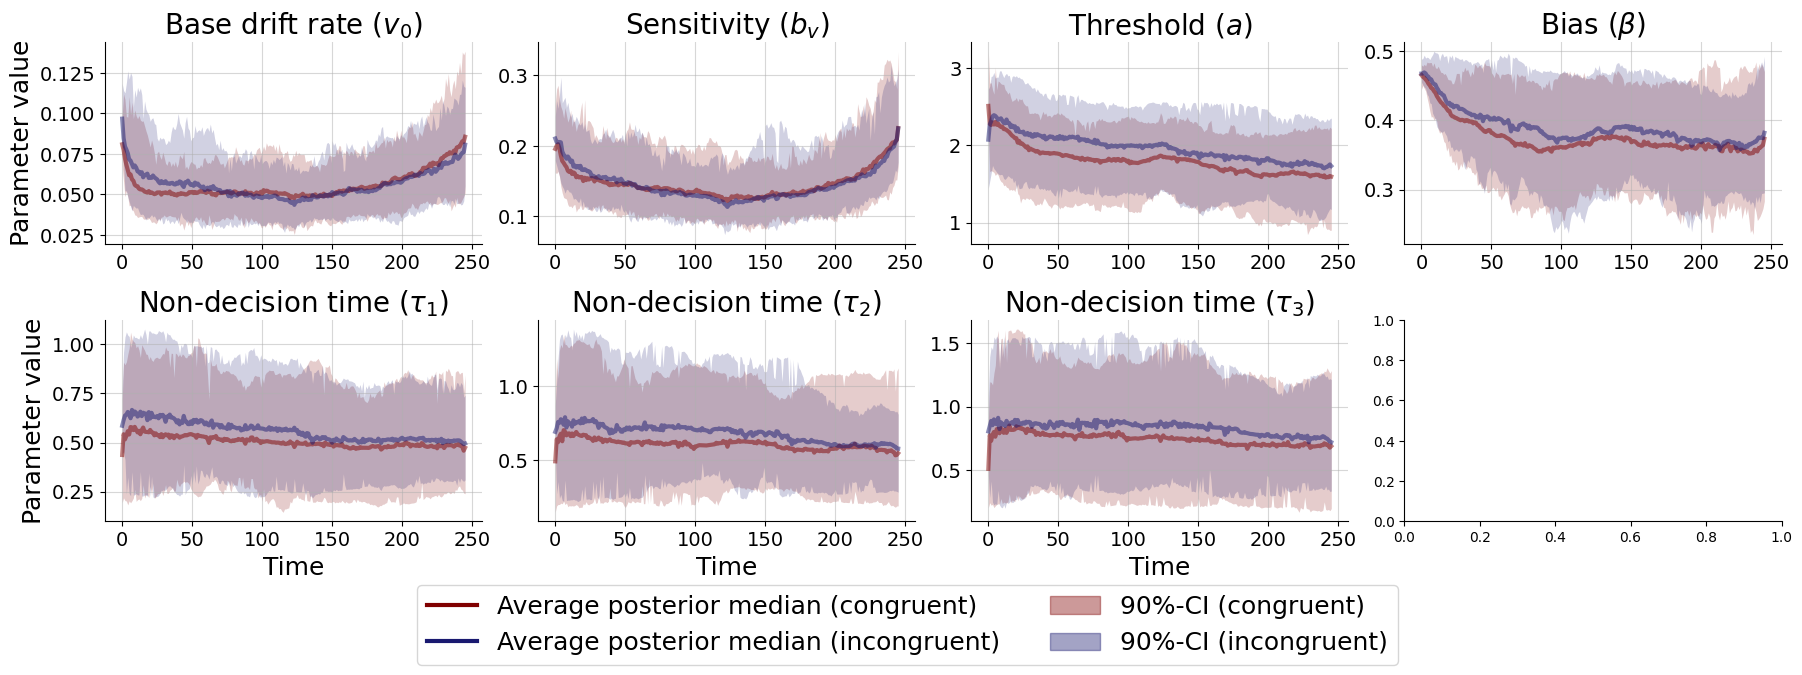

In [147]:
time = np.arange(local_post_mean_congruent.shape[0])
fig, axarr = plt.subplots(2, 4, figsize=(18, 6))
for i, ax in enumerate(axarr.flat):
    if i == 7:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        local_post_mean_congruent[:, i],
        color='maroon', alpha=0.5, linewidth=3
    )
    ax.fill_between(
        time,
        local_post_ci_congruent[0, :, i],
        local_post_ci_congruent[1, :, i],
        color='maroon', alpha=0.2, linewidth=0
    )
    ax.plot(
        time,
        local_post_mean_incongruent[:, i],
        color='midnightblue', alpha=0.5, linewidth=3
    )
    ax.fill_between(
        time,
        local_post_ci_incongruent[0, :, i],
        local_post_ci_incongruent[1, :, i],
        color='midnightblue', alpha=0.2, linewidth=0
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 4:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    if i > 3:
        ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

handles = [
    Line2D(
        xdata=[], ydata=[], markersize=10, lw=3,
        color='maroon', label='Average posterior median (congruent)'
    ),
    Line2D(
        xdata=[], ydata=[], markersize=10, lw=3,
        color='midnightblue', label='Average posterior median (incongruent)'
    ),
    Patch(
        color='maroon', label='Average posterior median (congruent)', alpha=0.4
    ),
    Patch(
        color='midnightblue', label='Average posterior median (incongruent)', alpha=0.4
    )
]

fig.subplots_adjust(hspace=0.5)
fig.legend(
    handles,
    ['Average posterior median (congruent)', 'Average posterior median (incongruent)',
    '90%-CI (congruent)', '90%-CI (incongruent)'],
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
    loc="center", ncol=2
)

sns.despine()
fig.tight_layout()
fig.savefig("../plots/average_param_trajectory.pdf", dpi=300, bbox_inches="tight")

## Posterior Re-simulation

In [145]:
emp_df = data_witness.loc[:, ("condition", "subject_id", "Antwort", "correct", "correctResponse", "Anzahl_Gesichter", "ValiditätenInv", "duration")]
emp_df = emp_df.rename(
    columns={
        "subject_id": "id", "Antwort": "resp", "correctResponse": "truth_context",
        "Anzahl_Gesichter": "face_context", "ValiditätenInv": "validity_context", "duration": "rt"})

emp_df.loc[:, "rt"] = emp_df.rt / 1000
emp_df.loc[emp_df["rt"] > 6.0, "rt"] = np.nan
emp_df.loc[emp_df["rt"] < 0.2, "rt"] = np.nan
emp_df['correct'] = emp_df['correct'].astype(str)
emp_df.loc[:, "correct"] = np.where(emp_df["correct"] == "True", 1, 0)

emp_df.loc[:, "condition"] = np.where(emp_df["condition"] == "Kongruenz Witness", 1, 0)
emp_df.loc[:, "truth_context"] = np.where(emp_df["truth_context"] == "Lüge", 0, 1)
emp_df.loc[:, "face_context"] = emp_df.face_context - 1
emp_df.loc[:, "validity_context"] = emp_df.validity_context - 0.5

In [146]:
reshaped_data = resim_data.reshape(-1, 7)
resim_df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'resp', 'truth_context', 'face_context', 'validity_context'])
resim_df["condition"] = np.where(resim_df["id"] < 43, 1, 0)
resim_df["correct"] = np.where(resim_df["resp"] == resim_df["truth_context"], 1, 0)

In [148]:
# grouped_data = resim_df.groupby(['condition', 'validity_context'])
# resim_summaries = grouped_data.agg({
#             'rt': ['median', "std"],
#             'correct': ['mean', "std"]
#         }).reset_index(drop=False)
# resim_summaries.columns = ["condition", "validity_context", 'rt_median', 'rt_std', 'acc', 'acc_std']

grouped_data = resim_df.groupby(['id', 'condition', 'validity_context'])
resim_summaries = grouped_data.agg({
            'rt': ['median'],
            'correct': ['mean']
        }).reset_index(drop=False)
resim_summaries.columns = ['id', "condition", "validity_context", 'rt_median', 'acc']

grouped_data = resim_summaries.groupby(['condition', 'validity_context'])
resim_summaries = grouped_data.agg({
            'rt_median': ['mean', 'std'],
            'acc': ['mean', 'std']
        }).reset_index(drop=False)
resim_summaries.columns = ["condition", "validity_context", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']

In [149]:
# grouped_data = emp_df.groupby(['condition', 'validity_context'])
# empiric_summaries = grouped_data.agg({
#             'rt': ['median', "std"],
#             'correct': ['mean', "std"]
#         }).reset_index(drop=False)
# empiric_summaries.columns = ["condition", "validity_context", 'rt_median', 'rt_std', 'acc', 'acc_std']
# empiric_summaries

grouped_data = emp_df.groupby(['id', 'condition', 'validity_context'])
empiric_summaries = grouped_data.agg({
            'rt': ['median'],
            'correct': ['mean']
        }).reset_index(drop=False)
empiric_summaries.columns = ['id', "condition", "validity_context", 'rt_median', 'acc']

grouped_data = empiric_summaries.groupby(['condition', 'validity_context'])
empiric_summaries = grouped_data.agg({
            'rt_median': ['mean', 'std'],
            'acc': ['mean', 'std']
        }).reset_index(drop=False)
empiric_summaries.columns = ["condition", "validity_context", 'avg_rt_median', 'std_rt_median', 'avg_acc', 'std_acc']

In [150]:
summaries = [empiric_summaries, resim_summaries]

ESCAPE = [-0.2, 0.2]
X_AXIS_VALUES = np.arange(8) * 1.5
COLOR = ['black', 'maroon']
CONDITION_NAMES = ['Incongruent', 'Congruent']
LABELS = ["Empiric", "Re-simulated"]

## Response Times

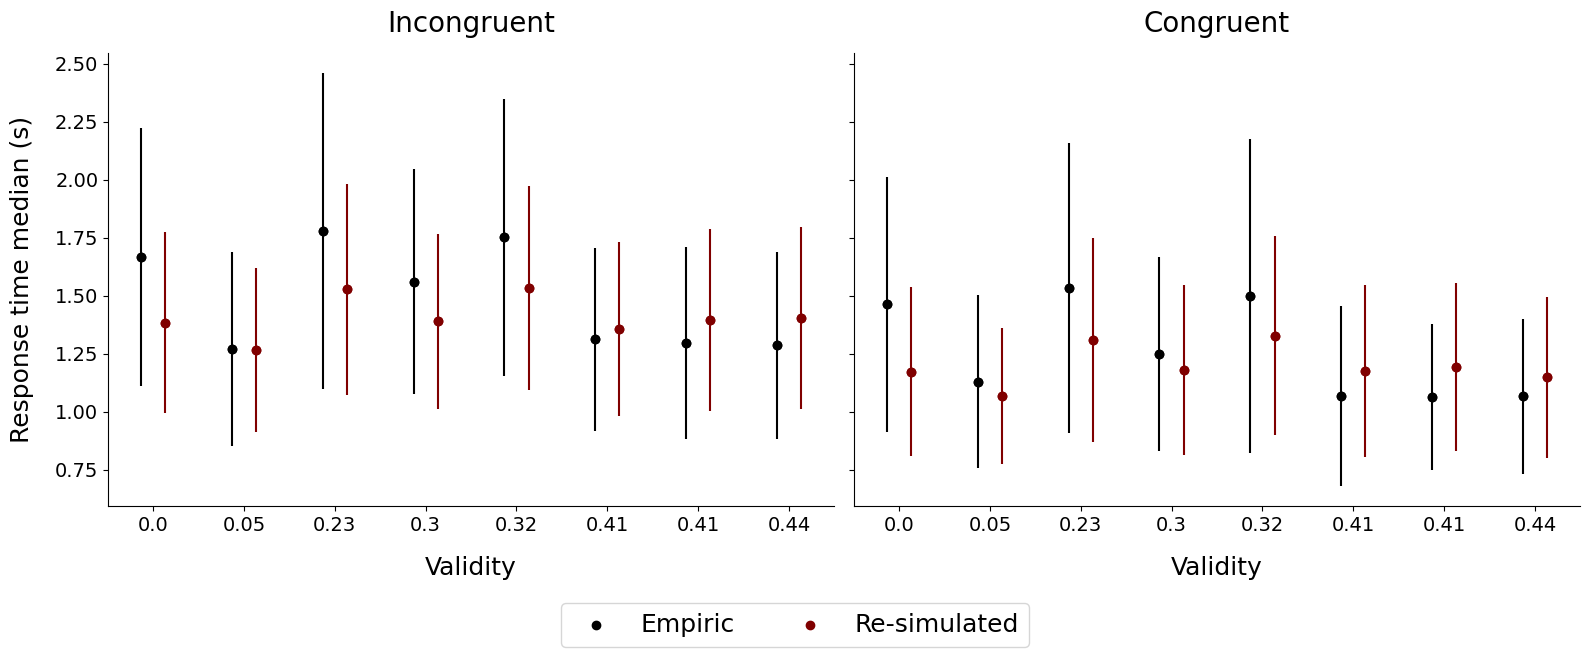

In [155]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, ax in enumerate(axarr.flat):
    for j in range(2):
        ax.scatter(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_rt_median'],
            color=COLOR[j], label=LABELS[j]
        )
        ax.errorbar(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_rt_median'],
            yerr= summaries[j].loc[summaries[j].condition == i, 'std_rt_median'],
            fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
        )
    ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity_context'].unique().round(decimals=2))
    ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_2)
    if i == 0:
        ax.set_ylabel("Response time median (s)", labelpad=15, fontsize=FONT_SIZE_2)
        fig.legend(
            fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
            loc="center", ncol=5
        )
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_title(CONDITION_NAMES[i], pad=15, fontsize=FONT_SIZE_1)
fig.subplots_adjust(hspace=0.5)

fig.tight_layout()
sns.despine()
fig.savefig("../plots/post_resim_rt.pdf", dpi=300, bbox_inches="tight")

## Accuracy

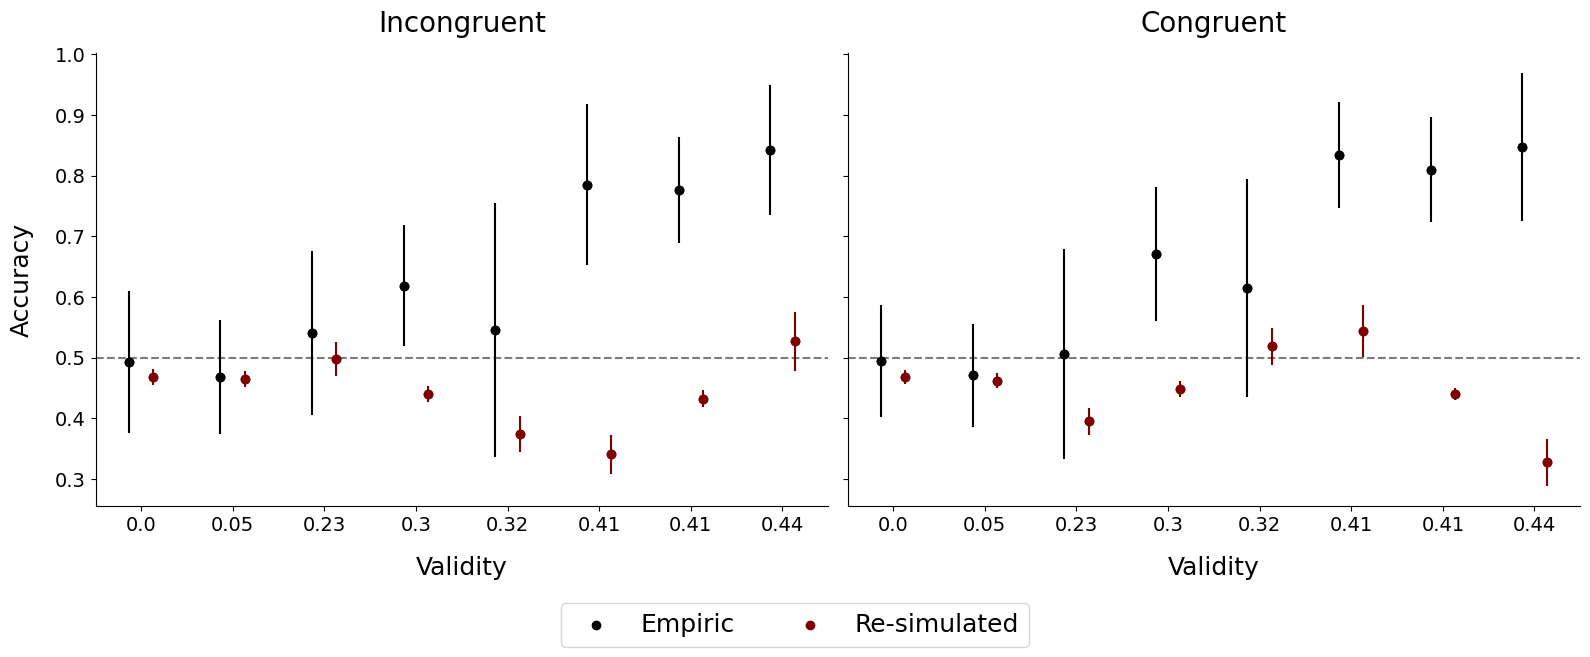

In [156]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, ax in enumerate(axarr.flat):
    for j in range(2):
        ax.scatter(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_acc'],
            color=COLOR[j], label=LABELS[j]
        )
        ax.errorbar(
            X_AXIS_VALUES + ESCAPE[j],
            summaries[j].loc[summaries[j].condition == i, 'avg_acc'],
            yerr= summaries[j].loc[summaries[j].condition == i, 'std_acc'],
            fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
        )
        ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
    ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity_context'].unique().round(decimals=2))
    ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_2)
    if i == 0:
        ax.set_ylabel("Accuracy", labelpad=15, fontsize=FONT_SIZE_2)
        fig.legend(
            fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
            loc="center", ncol=5
        )
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_title(CONDITION_NAMES[i], pad=15, fontsize=FONT_SIZE_1)
fig.subplots_adjust(hspace=0.5)

fig.tight_layout()
sns.despine()
fig.savefig("../plots/post_resim_accuracy.pdf", dpi=300, bbox_inches="tight")

In [154]:
# fig, axarr = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# for i, ax in enumerate(axarr.flat):
#     for j in range(2):
#         ax.scatter(
#             X_AXIS_VALUES + ESCAPE[j],
#             summaries[j].loc[summaries[j].condition == i, 'rt_median'],
#             color=COLOR[j], label=LABELS[j]
#         )
#         ax.errorbar(
#             X_AXIS_VALUES + ESCAPE[j],
#             summaries[j].loc[summaries[j].condition == i, 'rt_median'],
#             yerr= summaries[j].loc[summaries[j].condition == i, 'rt_std'],
#             fmt='o', color=COLOR[j], markersize=6, elinewidth=1.5, capsize=0
#         )
#     ax.set_xticks(X_AXIS_VALUES, empiric_summaries['validity_context'].unique().round(decimals=2))
#     ax.set_xlabel("Validity", labelpad=15, fontsize=FONT_SIZE_2)
#     if i == 0:
#         ax.set_ylabel("Response time median (s)", labelpad=15, fontsize=FONT_SIZE_2)
#         fig.legend(
#             fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
#             loc="center", ncol=5
#         )
#     ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
#     ax.set_title(CONDITION_NAMES[i], pad=15, fontsize=FONT_SIZE_1)
# fig.subplots_adjust(hspace=0.5)

# fig.tight_layout()
# sns.despine()